# 4.2 Logistic Regression 实验框架（Train + OOS）

这个 notebook 统一支持：
- 相同预处理逻辑（删列、取标签、只保留数值列）
- Pipeline 打包（imputer + scaler + logistic）
- 网格实验：`penalty`（l1/l2）× `class_weight`（None/balanced）× `C`
- 输出两张核心总表：
  - `metrics_df`：模型级指标（logloss/brier）
  - `pred_df_all`：样本级 OOS 概率结果

你后续只改配置，不需要重写流程代码。

In [52]:
# ========== Cell 1: 统一配置 ==========

from pathlib import Path
import json
import itertools

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss
from sklearn.calibration import calibration_curve

PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data" / "modeling"
DATA_DIR.mkdir(parents=True, exist_ok=True)

CFG = {
    "train_csv": DATA_DIR / "train_2015Q4_2022Q4.csv",
    "test_csv": DATA_DIR / "oos_2023Q1_2025Q4.csv",
    "label_col": "eps_beat",
    "id_cols": ["ticker", "quarter", "fiscal_quarter"],
    "drop_cols": [
        "next_quarter_estimated", "next_quarter_actual",
        "url_pr", "url_qa", "source_file_pr", "source_file_qa",
        "timestamp_pr", "timestamp_qa",
        "section_raw_pr", "section_raw_qa",
        "url", "source_file", "timestamp", "section", "id",
    ],
    "max_iter": 3000,
    "model_dir": DATA_DIR,
}

# 试验网格：可直接修改
GRID = {
    "penalty": ["l2", "l1"],
    "class_weight": [None, "balanced"],
    "C": [0.1, 0.3, 1.0, 3.0, 10.0],
}

print("train_csv:", CFG["train_csv"])
print("test_csv:", CFG["test_csv"])
print("GRID:", GRID)

train_csv: /Users/xinyuewang/Desktop/1.27/data/modeling/train_2015Q4_2022Q4.csv
test_csv: /Users/xinyuewang/Desktop/1.27/data/modeling/oos_2023Q1_2025Q4.csv
GRID: {'penalty': ['l2', 'l1'], 'class_weight': [None, 'balanced'], 'C': [0.1, 0.3, 1.0, 3.0, 10.0]}


In [53]:
# ========== Cell 2: 读取 train / test ==========

train_df = pd.read_csv(CFG["train_csv"])
test_df = pd.read_csv(CFG["test_csv"])

print("train shape:", train_df.shape)
print("test shape:", test_df.shape)
print("train columns sample:", train_df.columns[:12].tolist())
train_df.head(3)

train shape: (744, 74)
test shape: (330, 74)
train columns sample: ['ticker', 'quarter', 'adverb_ratio_pr', 'adverb_ratio_qa', 'adverb_ratio_zscore_pr', 'adverb_ratio_zscore_qa', 'automated_readability_pr', 'automated_readability_qa', 'coleman_liau_pr', 'coleman_liau_qa', 'dale_chall_pr', 'dale_chall_qa']


,ticker,quarter,adverb_ratio_pr,adverb_ratio_qa,adverb_ratio_zscore_pr,adverb_ratio_zscore_qa,automated_readability_pr,automated_readability_qa,coleman_liau_pr,coleman_liau_qa,...,words_per_sentence_zscore_pr,words_per_sentence_zscore_qa,eps_beat,next_quarter_estimated,next_quarter_actual,id,timestamp,url,source_file,section
0,AAPL,2015-Q4,0.013018,0.019011,-0.091593,0.176789,11.441274,8.946565,10.637844,7.904456,...,0.048181,-0.038618,1.0,0.81,0.82,79.0,2015-10-27 17:00,https://seekingalpha.com/article/3611256-apple...,transcripts/AAPL/Apple's (AAPL) CEO Tim Cook o...,PR+QA
1,AAPL,2016-Q1,0.014548,0.013830,0.068355,-0.133683,11.351406,8.101003,10.804548,7.949873,...,-0.215828,-1.513809,0.0,0.50,0.48,71.0,2016-01-26 17:00,https://seekingalpha.com/article/3836826-apple...,transcripts/AAPL/Apple's (AAPL) CEO Tim Cook O...,PR+QA
2,AAPL,2016-Q2,0.009893,0.020076,-1.398365,1.846627,11.185616,8.828381,10.810424,8.243896,...,-0.599980,-1.170718,1.0,0.35,0.36,23.0,2016-04-26 17:00,https://seekingalpha.com/article/3968300-apple...,transcripts/AAPL/Apple (AAPL) Timothy Donald C...,PR+QA


In [54]:
# ========== Cell 3: 统一取数函数（仅列选择 + 返回 X_df/y） ==========

def make_Xy(df, cfg, feature_names=None):
    xdf = df.copy()

    drop_existing = [c for c in cfg["drop_cols"] if c in xdf.columns]
    xdf = xdf.drop(columns=drop_existing, errors="ignore")

    if cfg["label_col"] not in xdf.columns:
        raise ValueError(f"missing label col: {cfg['label_col']}")

    y = xdf[cfg["label_col"]].astype(int).copy()

    id_existing = [c for c in cfg["id_cols"] if c in xdf.columns]
    xdf = xdf.drop(columns=[cfg["label_col"]] + id_existing, errors="ignore")

    xdf = xdf.select_dtypes(include=[np.number])

    if feature_names is not None:
        xdf = xdf.reindex(columns=feature_names)

    return xdf, y

In [55]:
# ========== Cell 4: 单次实验函数（train + OOS） ==========

def run_one(train_df, test_df, cfg, params):
    Xtr_df, ytr = make_Xy(train_df, cfg, feature_names=None)
    feature_names = Xtr_df.columns.tolist()
    Xte_df, yte = make_Xy(test_df, cfg, feature_names=feature_names)

    penalty = params["penalty"]
    solver = "liblinear" if penalty == "l1" else "lbfgs"

    pipe = Pipeline(steps=[
        ("impute", SimpleImputer(strategy="mean")),
        ("scale", StandardScaler()),
        ("clf", LogisticRegression(
            penalty=penalty,
            C=params["C"],
            solver=solver,
            max_iter=cfg["max_iter"],
            class_weight=params.get("class_weight", None),
        ))
    ])

    pipe.fit(Xtr_df, ytr)
    p = pipe.predict_proba(Xte_df)[:, 1]

    m = {
        "penalty": penalty,
        "C": float(params["C"]),
        "class_weight": str(params.get("class_weight", None)),
        "n_train": int(len(ytr)),
        "n_test": int(len(yte)),
        "y_train_mean": float(np.mean(ytr)),
        "y_test_mean": float(np.mean(yte)),
        "logloss_oos": float(log_loss(yte, p)),
        "brier_oos": float(brier_score_loss(yte, p)),
    }

    clf = pipe.named_steps["clf"]
    coef_df = pd.DataFrame({
        "feature": feature_names,
        "coef": clf.coef_[0],
    })

    quarter_col = "fiscal_quarter" if "fiscal_quarter" in test_df.columns else ("quarter" if "quarter" in test_df.columns else None)
    if quarter_col is None:
        raise ValueError("test_df missing quarter/fiscal_quarter")

    res = test_df[["ticker", quarter_col]].copy()
    res = res.rename(columns={quarter_col: "fiscal_quarter"})
    res["p_text"] = p
    res["actual"] = yte.values

    return pipe, m, coef_df, res

In [56]:
# ========== Cell 5: 网格实验函数 ==========

def run_experiment(train_df, test_df, cfg, grid):
    runs = []
    coef_all = []
    pred_all = []
    model_store = {}

    keys = list(grid.keys())
    values = [grid[k] for k in keys]

    run_id = 0
    for combo in itertools.product(*values):
        params = dict(zip(keys, combo))
        run_id += 1
        model_id = f"run_{run_id:03d}"

        pipe, m, coef_df, res = run_one(train_df, test_df, cfg, params)

        m["model_id"] = model_id
        runs.append(m)

        coef_df = coef_df.copy()
        coef_df["model_id"] = model_id
        coef_all.append(coef_df)

        res = res.copy()
        res["model_id"] = model_id
        pred_all.append(res)

        model_store[model_id] = pipe

    metrics_df = pd.DataFrame(runs).sort_values(["logloss_oos", "brier_oos"]).reset_index(drop=True)
    coef_df_all = pd.concat(coef_all, ignore_index=True)
    pred_df_all = pd.concat(pred_all, ignore_index=True)
    return metrics_df, coef_df_all, pred_df_all, model_store

In [57]:
# ========== Cell 6: 运行实验 ==========

metrics_df, coef_df_all, pred_df_all, model_store = run_experiment(train_df, test_df, CFG, GRID)

print("实验完成")
print("模型数量:", len(metrics_df))
metrics_df.head(10)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalt

实验完成
模型数量: 20


,penalty,C,class_weight,n_train,n_test,y_train_mean,y_test_mean,logloss_oos,brier_oos,model_id
0,l1,0.3,None,744,330,0.770161,0.857576,0.413981,0.126831,run_012
1,l1,0.1,None,744,330,0.770161,0.857576,0.416165,0.125944,run_011
2,l2,0.1,None,744,330,0.770161,0.857576,0.416829,0.128259,run_001
3,l1,1.0,None,744,330,0.770161,0.857576,0.419243,0.129250,run_013
4,l2,0.3,None,744,330,0.770161,0.857576,0.425079,0.131281,run_002
5,l1,3.0,None,744,330,0.770161,0.857576,0.431885,0.133650,run_014
6,l2,1.0,None,744,330,0.770161,0.857576,0.434025,0.134405,run_003
7,l2,3.0,None,744,330,0.770161,0.857576,0.439477,0.136211,run_004
8,l1,10.0,None,744,330,0.770161,0.857576,0.439827,0.136361,run_015
9,l2,10.0,None,744,330,0.770161,0.857576,0.441625,0.136885,run_005


In [58]:
# ========== Cell 7: 查看最佳模型 ==========

best = metrics_df.iloc[0]
best_id = best["model_id"]
print("best model:")
print(best.to_string())

coef_best = coef_df_all[coef_df_all["model_id"] == best_id].sort_values("coef")
print("\n最负向 15:")
print(coef_best.head(15).to_string(index=False))
print("\n最正向 15:")
print(coef_best.tail(15).to_string(index=False))

best model:
penalty               l1
C                    0.3
class_weight        None
n_train              744
n_test               330
y_train_mean    0.770161
y_test_mean     0.857576
logloss_oos     0.413981
brier_oos       0.126831
model_id         run_012

最负向 15:
                     feature      coef model_id
       words_per_sentence_pr -0.188832  run_012
            lm_modal_weak_qa -0.128513  run_012
      lm_litigious_zscore_pr -0.072587  run_012
                  n_words_qa -0.069449  run_012
   lm_subjectivity_zscore_qa -0.065459  run_012
   lm_modal_strong_zscore_pr -0.065419  run_012
           flesch_kincaid_qa -0.061046  run_012
words_per_sentence_zscore_qa -0.059953  run_012
              n_sentences_qa -0.053660  run_012
            lm_modal_weak_pr -0.046248  run_012
    lm_uncertainty_zscore_pr -0.017794  run_012
   lm_subjectivity_zscore_pr -0.016546  run_012
     pronoun_plural_ratio_pr  0.000000  run_012
       words_per_sentence_qa  0.000000  run_012
         

In [59]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test, p_test)

0.587987987987988

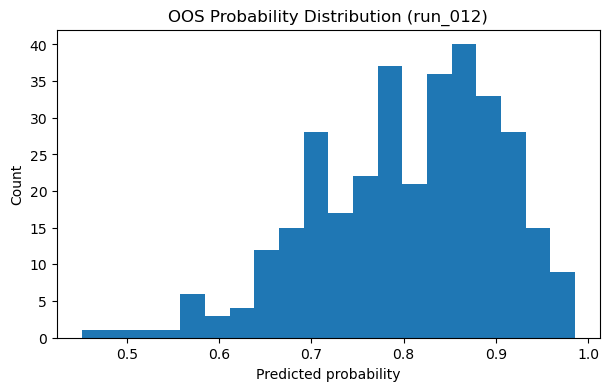

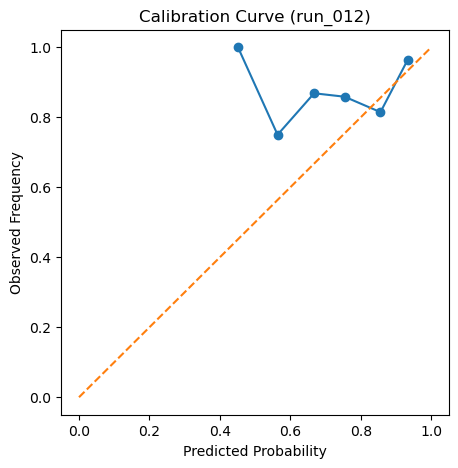

In [60]:
# ========== Cell 8: 最佳模型概率分布 + 校准曲线 ==========

best_pred = pred_df_all[pred_df_all["model_id"] == best_id].copy()
y = best_pred["actual"].astype(int).values
p = best_pred["p_text"].astype(float).values

plt.figure(figsize=(7, 4))
plt.hist(p, bins=20)
plt.title(f"OOS Probability Distribution ({best_id})")
plt.xlabel("Predicted probability")
plt.ylabel("Count")
plt.show()

prob_true, prob_pred = calibration_curve(y, p, n_bins=10)
plt.figure(figsize=(5, 5))
plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title(f"Calibration Curve ({best_id})")
plt.xlabel("Predicted Probability")
plt.ylabel("Observed Frequency")
plt.show()

In [61]:
# ========== Cell 9: 保存总表 + 最佳模型 ==========

out_dir = CFG["model_dir"]
metrics_path = out_dir / "exp_metrics_logit_grid.csv"
pred_path = out_dir / "exp_oos_predictions_logit_grid.csv"
coef_path = out_dir / "exp_coefs_logit_grid.csv"

best_model_path = out_dir / f"best_pipe_{best_id}.pkl"
best_pred_path = out_dir / f"best_oos_probabilities_{best_id}.csv"
best_summary_path = out_dir / "best_model_summary.json"

metrics_df.to_csv(metrics_path, index=False)
pred_df_all.to_csv(pred_path, index=False)
coef_df_all.to_csv(coef_path, index=False)

joblib.dump(model_store[best_id], best_model_path)
best_pred.to_csv(best_pred_path, index=False)

best_summary = best.to_dict()
with open(best_summary_path, "w", encoding="utf-8") as f:
    json.dump(best_summary, f, ensure_ascii=False, indent=2)

print("已保存:")
print(" -", metrics_path)
print(" -", pred_path)
print(" -", coef_path)
print(" -", best_model_path)
print(" -", best_pred_path)
print(" -", best_summary_path)

已保存:
 - /Users/xinyuewang/Desktop/1.27/data/modeling/exp_metrics_logit_grid.csv
 - /Users/xinyuewang/Desktop/1.27/data/modeling/exp_oos_predictions_logit_grid.csv
 - /Users/xinyuewang/Desktop/1.27/data/modeling/exp_coefs_logit_grid.csv
 - /Users/xinyuewang/Desktop/1.27/data/modeling/best_pipe_run_012.pkl
 - /Users/xinyuewang/Desktop/1.27/data/modeling/best_oos_probabilities_run_012.csv
 - /Users/xinyuewang/Desktop/1.27/data/modeling/best_model_summary.json
